<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>
<font size=4>
<br/>
</div>

# Personal Data

In [ ]:
# Set your student number
student_number =  99101246
Name = 'Danial'
Last_Name = 'Ayati'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [33]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [34]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [35]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [36]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [37]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

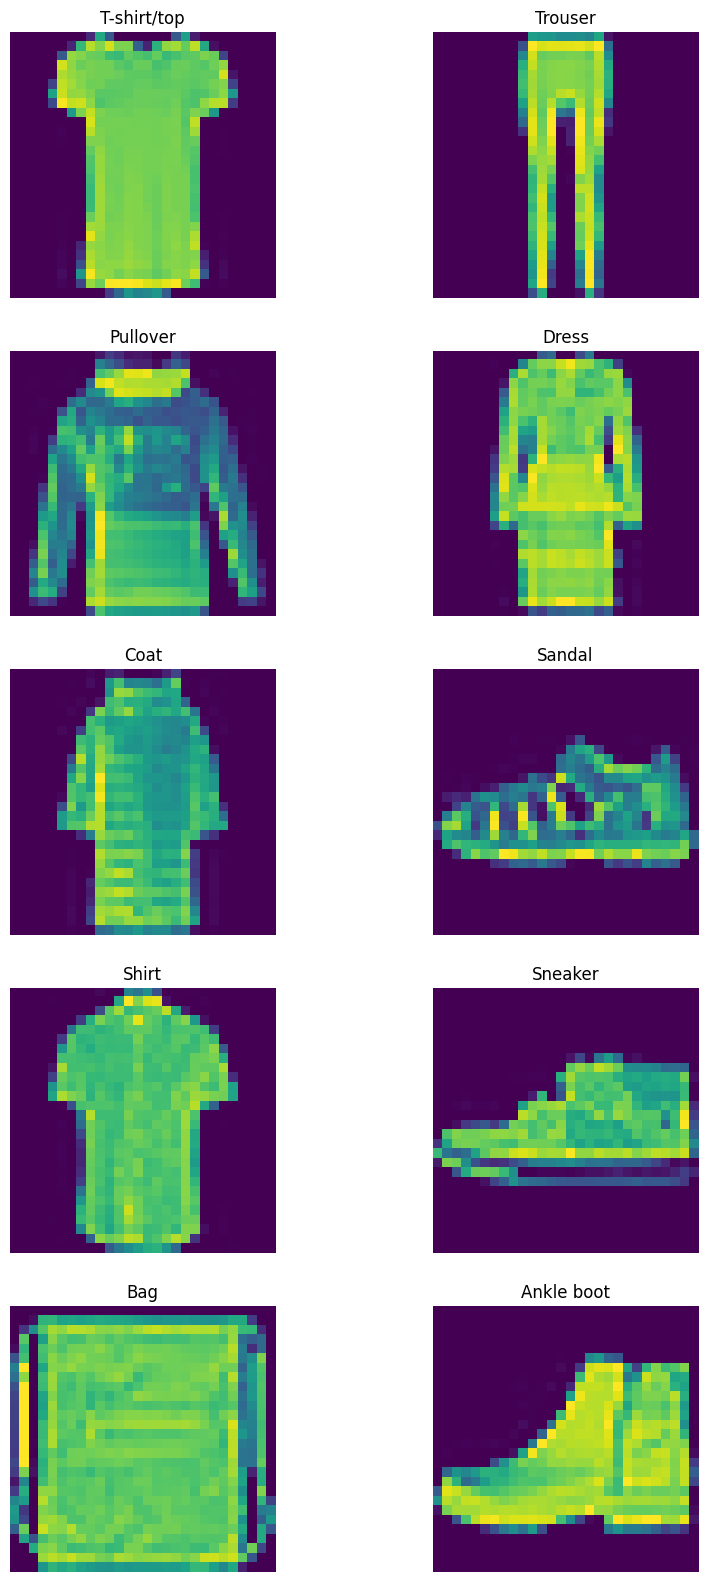

In [38]:
# Get list of classes from the training set
list_of_classes = train_set.classes
selected_images = []

# Loop through each class
for class_name in list_of_classes:
    # Get indices of images belonging to the current class
    indices = np.where(train_set.targets == list_of_classes.index(class_name))[0]
    # Choose a random index
    random_idx = np.random.randint(len(indices))
    # Get the image and label at the random index
    img, lbl = train_set[indices[random_idx]]
    # Append the image and label to the list
    selected_images.append((img, lbl))

# Create a figure for plotting
plt.figure(figsize=(10, 20))

# Loop through the selected images
for idx, (img, lbl) in enumerate(selected_images):
    img_np = np.transpose(img, (1, 2, 0))
    class_lbl = list_of_classes[lbl]


    plt.subplot(5, 2, idx + 1)
    plt.imshow(img_np)
    plt.title(class_lbl)
    plt.axis('off')

# Display the plot
plt.show()


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [39]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [41]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [42]:
def affine_forward(x, w, b):
    out = torch.matmul(x, w) + b
    return out

def relu(x):
    out = torch.max(torch.zeros_like(x), x)
    return out

Function `model` returns output of the whole model for the input `x` using the parameters:

In [43]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)

    output = x
    for i in range(num_layers):
      w = parameters[f'w{i}']
      b = parameters[f'b{i}']

      output = relu(affine_forward(output, w, b))

    return output

Implementing cross entropy loss:

In [44]:
def cross_entropy_loss(scores, y):
    n = len(y)
    softmax_scores = torch.softmax(scores, dim=1)
    log_softmax_scores = softmax_scores[range(n), y]
    loss = -torch.log(log_softmax_scores).sum()

    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [45]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    for param in parameters.values():
        param.data = param.data - learning_rate * param.grad
        param.grad.zero_()

Training functions:

In [46]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):

    correct = np.sum(y_pred == y_true)
    acc = correct / len(y_pred)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):

    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []


    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        train_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())


    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    #print(f'Accuracy of train set: {acc}')
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    test_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)

        test_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    #print(f'Accuracy of {set_name} set: {acc}')
    print(f'Epoch: {epoch}, {set_name} Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

    return test_loss, acc

In [47]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [48]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):

    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
         train_loss, train_acc = train(train_loader, learning_rate, epoch+1)
         test_loss, test_acc = validate(test_loader, epoch+1, set_name='Test')
         train_losses.append(train_loss)
         test_losses.append(test_loss)
         train_accuracies.append(train_acc)
         test_accuracies.append(test_acc)


    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()

    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

Epoch: 1, Train Loss: 94625.5598, Accuracy: 0.4679
Epoch: 1, Test Loss: 82010.6462, Accuracy: 0.5435
Epoch: 2, Train Loss: 82494.2743, Accuracy: 0.5516
Epoch: 2, Test Loss: 80056.8747, Accuracy: 0.5653
Epoch: 3, Train Loss: 80712.7699, Accuracy: 0.5590
Epoch: 3, Test Loss: 79644.5667, Accuracy: 0.5598
Epoch: 4, Train Loss: 79804.6319, Accuracy: 0.5637
Epoch: 4, Test Loss: 78573.4385, Accuracy: 0.5641
Epoch: 5, Train Loss: 78965.3967, Accuracy: 0.5638
Epoch: 5, Test Loss: 75383.2356, Accuracy: 0.5597
Epoch: 6, Train Loss: 72718.9691, Accuracy: 0.5846
Epoch: 6, Test Loss: 72374.5987, Accuracy: 0.6169
Epoch: 7, Train Loss: 70917.5244, Accuracy: 0.6023
Epoch: 7, Test Loss: 68884.8237, Accuracy: 0.6121
Epoch: 8, Train Loss: 70112.2009, Accuracy: 0.6086
Epoch: 8, Test Loss: 69437.6896, Accuracy: 0.6126
Epoch: 9, Train Loss: 61583.6507, Accuracy: 0.6695
Epoch: 9, Test Loss: 56567.6048, Accuracy: 0.6928
Epoch: 10, Train Loss: 56423.5916, Accuracy: 0.7073
Epoch: 10, Test Loss: 55733.6845, Accur

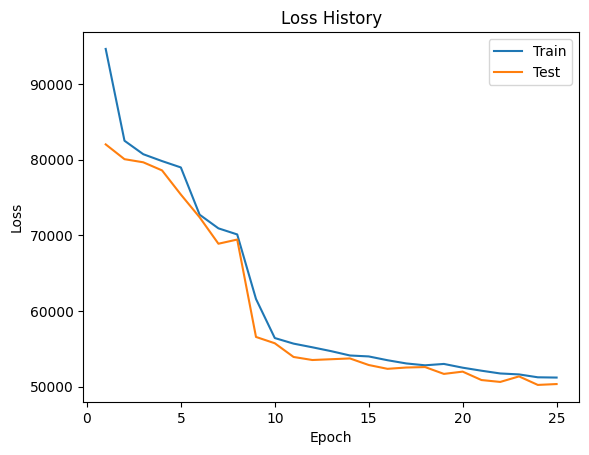

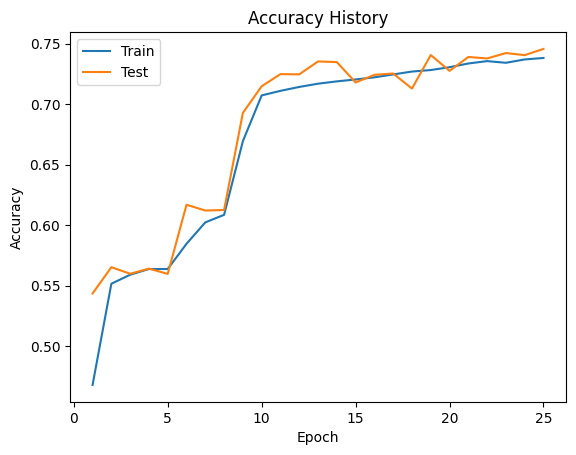

In [49]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [50]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.74575


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

<ipython-input-53-3f1474a4e7fa>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image)


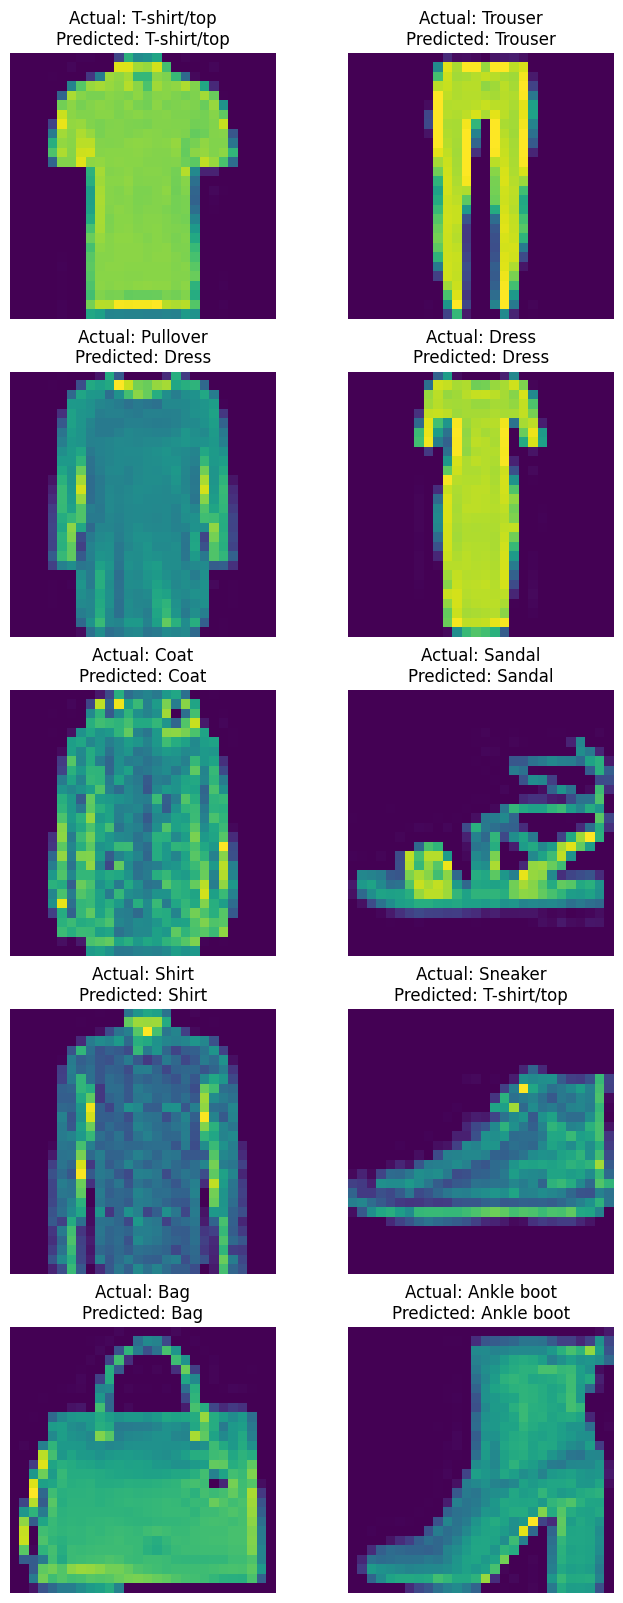

In [53]:
validation_images = []

for class_name in class_names:
    class_indices = np.where(test_set.targets == class_names.index(class_name))[0]
    random_index = np.random.randint(len(class_indices))
    image, label = test_set[class_indices[random_index]]
    validation_images.append((image, label))


plt.figure(figsize=(8, 20))

for i, (image, label) in enumerate(validation_images):
    image_np = np.transpose(image,(1, 2, 0))
    image=torch.tensor(image)
    image=image.to(device)
    class_name = class_names[label]
    p = model(image, parameters)
    predicted_label = p.argmax(dim=-1).item()

    plt.subplot(5, 2, i + 1)
    plt.imshow(image_np)
    plt.title(f'Actual: {class_name}\nPredicted: {class_names[predicted_label]}')
    plt.axis('off')

plt.show()
